In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as optimize

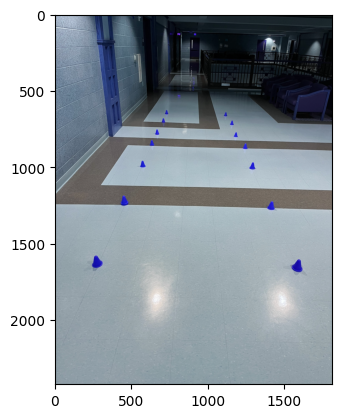

In [3]:
#reading in the image
path = "red.png" #change to wherever image is
img = cv2.imread(path)
plt.imshow(img)
plt.show()

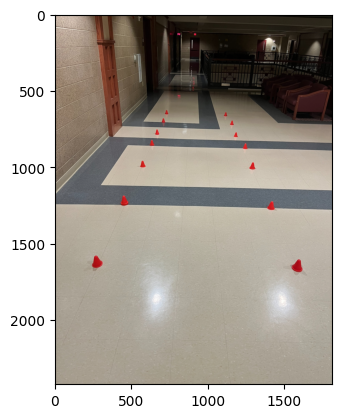

In [4]:
#changing image from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()


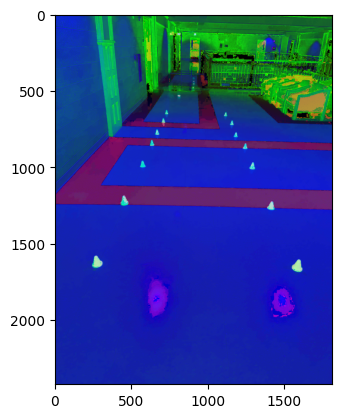

In [5]:
#changing image to HSV
#The Hue Saturation Value separates image intensity from color information
img_HSV = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
plt.imshow(img_HSV)
plt.show()

In [6]:
#defining color thresholds
img_thresh_low = cv2.inRange(img_HSV, np.array([0, 135, 135]), np.array([15, 255, 255]))
img_thresh_high = cv2.inRange(img_HSV, np.array([159, 135, 135]), np.array([179, 255, 255]))
img_thresh = cv2.bitwise_or(img_thresh_low, img_thresh_high)

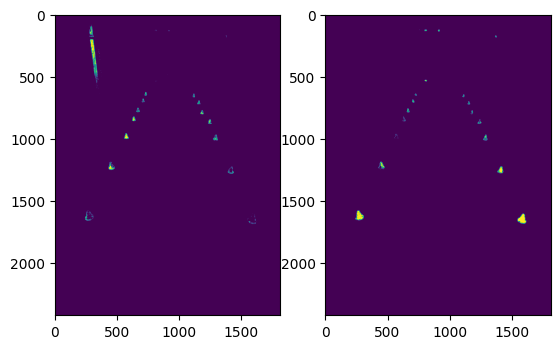

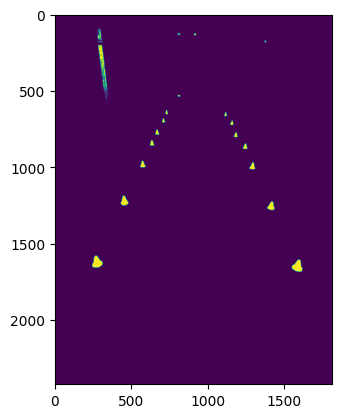

In [7]:
#examinging thresholds
f, axarr = plt.subplots(nrows=1, ncols=2)
axarr[0].imshow(img_thresh_low)
axarr[1].imshow(img_thresh_high)
plt.show()

plt.imshow(img_thresh)
plt.show()

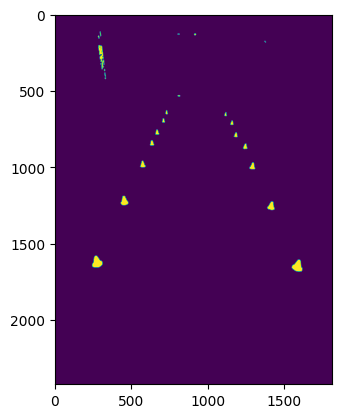

In [8]:
#use 5x5 kernel to remove noise
kernel = np.ones((5, 5))
img_thresh_opened = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kernel)
plt.imshow(img_thresh_opened)
plt.show()

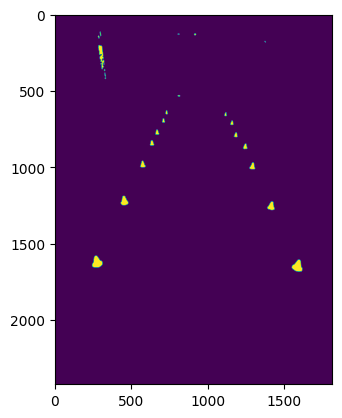

In [9]:
#blur image to further remove noise
img_thresh_blurred = cv2.medianBlur(img_thresh_opened, 5)
plt.imshow(img_thresh_blurred)
plt.show()

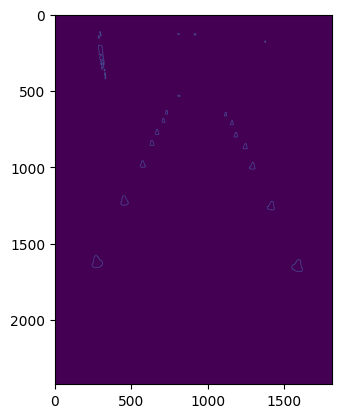

25


In [10]:
#using canny to detect edges
img_edges = cv2.Canny(img_thresh_blurred, 70, 255)
plt.imshow(img_edges)
plt.show()

#finds contours using edges
contours, _ = cv2.findContours(np.array(img_edges), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_contours = np.zeros_like(img_edges)
print(len(contours))

In [11]:
#place contours on image
cv2.drawContours(img_contours, contours, -1, (255,255,255), 2)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
#use RDP to reduce number of points in curves to simplify contours
approx_contours = []
for c in contours:
    approx = cv2.approxPolyDP(c, 10, closed = True)
    approx_contours.append(approx)
img_approx_contours = np.zeros_like(img_edges)
cv2.drawContours(img_approx_contours, approx_contours, -1, (255,255,255), 1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
#finds convex hulls
all_convex_hulls = []
for ac in approx_contours:
    all_convex_hulls.append(cv2.convexHull(ac))
img_all_convex_hulls = np.zeros_like(img_edges)
cv2.drawContours(img_all_convex_hulls, all_convex_hulls, -1, (255,255,255), 2)

#check hulls  have 3 to 10 points
convex_hulls_3to10 = []
for ch in all_convex_hulls:
    if 3 <= len(ch) <= 10:
        convex_hulls_3to10.append(cv2.convexHull(ch))
img_convex_hulls_3to10 = np.zeros_like(img_edges)
cv2.drawContours(img_convex_hulls_3to10, convex_hulls_3to10, -1, (255,255,255), 2)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [14]:
#determines if hull is pointing up
# finds mid horizontal line to divide points into upper and lower
# returns whether all upper points have x-values between the extremes of the lower points' x values
def convex_hull_pointing_up(ch):
    points_above_center, points_below_center = [], []
    x, y, w, h = cv2.boundingRect(ch)
    aspect_ratio = w / h 
    if aspect_ratio < 0.8:
        vertical_center = y + h / 2
        for point in ch:
            if point[0][1] < vertical_center:
                points_above_center.append(point)
            elif point[0][1] >= vertical_center:
                points_below_center.append(point)
        left_x = points_below_center[0][0][0]
        right_x = points_below_center[0][0][0]
        for point in points_below_center:
            if point[0][0] < left_x:
                left_x = point[0][0]
            if point[0][0] > right_x:
                right_x = point[0][0]
        for point in points_above_center:
            if (point[0][0] < left_x) or (point[0][0] > right_x):
                return False
    else:
        return False
    return True

In [15]:
#determines if contour is a cone and bounds with a rectangle
cones = []
bounding_rects = []
for ch in convex_hulls_3to10:
    if convex_hull_pointing_up(ch):
        cones.append(ch)
        rect = cv2.boundingRect(ch)
        bounding_rects.append(rect)

#eliminates contours pointing upside down
img_cones = np.zeros_like(img_edges)
cv2.drawContours(img_cones, cones, -1, (255,255,255), 2)
img_res = img_rgb.copy()
cv2.drawContours(img_res, cones, -1, (255,255,255), 2)
for rect in bounding_rects:
    cv2.rectangle(img_res, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (1, 255, 1), 3)

In [16]:
#function to use least squares reg to get parametes for best fit line
def least_squares(x, y):
    def func(x, a, b):
        return a * x + b
    popt, pcov = optimize.curve_fit(func, x, y)
    return popt
img_out = img_rgb.copy()

In [17]:
cone_points_left = [(rect[0] + rect[2]/2, rect[1] + rect[3]/2) for rect in bounding_rects if rect[0] + rect[2]/2 < img_res.shape[1]/2]
cone_points_right = [(rect[0] + rect[2]/2, rect[1] + rect[3]/2) for rect in bounding_rects if rect[0] + rect[2]/2 > img_res.shape[1]/2]

In [18]:
#generate best fit lines
a1, b1 = least_squares(np.array([i[0] for i in cone_points_left]), np.array([i[1] for i in cone_points_left]))
a2, b2 = least_squares(np.array([i[0] for i in cone_points_right]), np.array([i[1] for i in cone_points_right]))

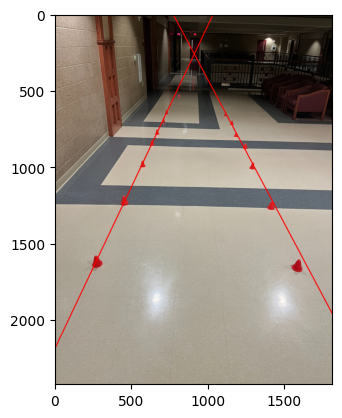

In [19]:
#output final answer
cv2.line(img_out, [0, int(b1)], [3000, int((3000 * a1) + b1)], (255,1,1), 5)
cv2.line(img_out, [0, int(b2)], [3000, int((3000 * a2) + b2)], (255,1,1), 5)
plt.imshow(img_out)
plt.savefig("answer.png")
plt.show()